# Homework 3 - Larger Graphical Model

Brennan McFarland  
bfm21

## Problem Description

Suppose we want to monitor the success of a network packet transmission relative to various factors affecting the reliability of the network.  This information could be used to infer the condition of the network or troubleshoot problems based on such limited information as whether the packet was successfully transmitted and nothing else.

## Background

Our transmission utilizes an acknowledgement-based protocol such as TCP where the receiver can acknowledge back to the host which packets it has received.  This is a widespread technique to increase protocol reliability, as the sender can send a duplicate of the original packet if it has not received the corresponding acknowledgement within a given period of time.  Since our network will be affected by the error rate in a given transmission, we will also assume that this protocol is either not error-correcting or that repeated error-correction is liable to decrease the chances of successful packet transmission, for example by requiring more data to be sent that could potentially be lost.

## Probability Model

For our probability model we will take into account the following variables:

 - $V$ : successful packet transmission - binary (P is for probability and we use S and T elsewhere)
 - $D$ : number of duplicate packets sent thus far - discrete
 - $A$ : time since last packet acknowledgement - discrete (measured in time steps)
 - $E$ : packet error rate - discrete (measured in # errors)
 - $L$ : network load - discrete (measured in multiples of packets)
 - $U$ : network is up - binary
 - $S$ : sender is up - binary
 - $R$ : receiver is up - binary
 - $C$ : connection between sender and receiver is up - binary
 
Let the network then be defined by the following probabilities:



In [2]:
#TODO: once we have nice probs for the model, fill them in the above

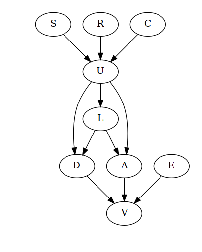

In [4]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as imtool

image_format = 'png'
dot = Digraph(format=image_format)
dot.node('V', 'V')
dot.node('D', 'D')
dot.node('A', 'A')
dot.node('E', 'E')
dot.node('L', 'L')
dot.node('U', 'U')
dot.node('S', 'S')
dot.node('R', 'R')
dot.node('C', 'C')
dot.edges(['DV', 'AV', 'EV', 'LD', 'LA', 'UL', 'UD', 'UA', 'CU', 'RU', 'SU'])
path = 'exercise1-graph'
dot.render(path)
imorg = imtool.imread(path + '.' + image_format)
plt.axis('off')
plt.imshow(imorg) # NOTE: the first time it might not show the image, if it doesn't just execute this block again

## Building the Model in Python

In [5]:
from pgmpy.models import BayesianModel as bysmodel
from pgmpy.factors.discrete import TabularCPD as tcpd
from pgmpy.factors.continuous import ContinuousFactor
import scipy
import math
import numpy as np

Before we define our model, let us first define a few helper functions to quickly generate the corresponding probability distributions.  Note that we normalize the distributions because rounding error is introduced when we calculate the probabilities in the distribution and the sum probability of all possible events given a particular set of causes must sum exactly to 1.  Normalization of our pdfs is especially important because we define the distribution directly rather than via log values, which would be more accurate, but either way the pgmpy library forces us to validate our distribution.  Additionally, if in the process of calculating a particular distribution we end up overflowing our floats, we fall back to using integer math, which has the side effect of introducing more error.  Normalizing our distribution at the end solves all these problems simultaneously.

In [29]:
def binom(w, n, p):
    if(w < 0 or w > n):
       return 0
    # it stops trying to convert to float before calculating if the numbers are too large
    try:
        return float(math.factorial(n))/float(math.factorial(n-w)*math.factorial(w))*(p**w)*((1-p)**(n-w))
    except:
        return math.factorial(n)/(math.factorial(n-w)*math.factorial(w))*(p**w)*((1-p)**(n-w))

def pdf_binom(n, p):
    return [binom(i, n, p) for i in range(n)]

# TODO: make sure it actually does this or change the comment if it works out anyway
# return an array for a decreasing discrete distribution
def decreasing_distribution(numvals):
    dist = pdf_binom(numvals, .2)
    return [dist]

# makes sure the values in the distribution all sum exactly to 1
def fix_dist_round_error(dist):
    dist_sum = np.sum(dist)
    if dist_sum < 1.0:
        was_fixed = True
        dist[len(dist)-1] = 1.0-dist_sum + dist[len(dist)-1]
    last_nonzero = len(dist)-1
    while dist_sum > 1.0:
        was_fixed = True
        # print(dist_sum)
        dist[last_nonzero] = max(0, dist[last_nonzero]-(dist_sum-1.0))
        last_nonzero -= 1
        dist_sum = np.sum(dist)
    if np.sum(dist) != 1.0:
        return fix_dist_round_error(dist)
    print(np.sum(dist))
    return dist

# TODO: define better distributions

# define the range (ie number of possible values) of all variables
# the range of all binary variables is 2 values, true or false; we redundantly define them here for clarity
ranges = {'V': 2, 'S': 2, 'R': 2, 'C': 2, 'U': 2, 'D': 3, 'A': 10, 'E': 5, 'L': 10}

# prior probability
# we normalize because rounding error is introduced when generating the distribution
def ppd(prior):
    dist = tcpd(variable=prior,
                variable_card=ranges[prior],
                values=decreasing_distribution(ranges[prior]))
    dist.normalize()
    return dist

# conditional probability
# we normalize because rounding error is introduced when generating the distribution
def cpd(*variables):
    dist = tcpd(variable=variables[0], variable_card=ranges[variables[0]],
               evidence=variables[1:], evidence_card=[ranges[i] for i in variables[1:]],
               values=decreasing_distribution(np.prod([ranges[i] for i in variables])))
    dist.normalize()
    return dist


Defining our model is then just a matter of defining the causal relationships between variables and calling the above helpers to generate their prior and conditional probability distributions:

In [30]:
# define model with connections between variables
model = bysmodel([('D', 'V'), ('A', 'V'), ('E', 'V'), ('L', 'D'), 
                  ('L', 'A'), ('U', 'D'), ('U', 'L'), ('U', 'A'),
                  ('S', 'U'), ('R', 'U'), ('C', 'U')])

In [31]:
# define our prior and conditional pdfs
priorS = ppd('S')
priorR = ppd('R')
priorC = ppd('C')
priorE = ppd('E')
cpdV = cpd('V', 'D', 'A', 'E')
cpdA = cpd('A', 'L', 'U')
cpdD = cpd('D', 'L', 'U')
cpdL = cpd('L', 'U')
cpdU = cpd('U', 'S', 'R', 'C')

# add distributions to the model
model.add_cpds(priorS, priorR, priorC, priorE, cpdV, cpdA, cpdD, cpdL, cpdU)
# check consistency
model.check_model()

True

## Solving an Example Problem: Comparison of Methods

Given this network, let us compare different methods of computing a particular conditional probability.  Let's suppose we want to figure out the most probable network load ($L$) given that the sender and receiver are both up ($S,R$), that 2 duplicate packets have been sent thus far ($D$) and that packet transmission was successful ($V$).  In short, we want to derive the conditional probability distribution  
$P(L|S,R,D=2,V)$

### Variable Elimination

In [39]:
def solve_and_display(solver, model):
    x = (solver.query(['L'],
                      evidence={'S' : 1, 'R' : 1, 'D' : 2, 'V' : 1})
                                 ['L'].values)
    print(x)
    plt.bar(range(0,ranges['L']), x)
    plt.grid()
    plt.show()

[2.32708591e-01 7.44075250e-01 2.31624215e-02 5.36816531e-05
 5.52759125e-08 2.15226229e-11 2.74422979e-15 1.37134263e-19
 3.57755631e-24 2.42339235e-29]


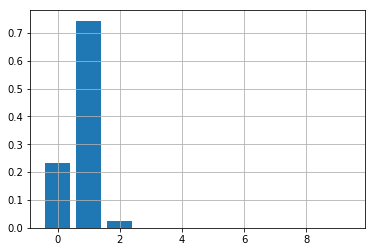

In [40]:
from pgmpy.inference import VariableElimination

VESolver = VariableElimination(model)
solve_and_display(VESolver, model)


### Belief Propagation

In [41]:
from pgmpy.inference import BeliefPropagation

BPSolver = BeliefPropagation(model)
BPSolver.calibrate()
solve_and_display(BPSolver, model)

TypeError: object of type 'dict_keyiterator' has no len()

### Monte Carlo Sampling